This notebook implements a three-dimensional flocking simulation and compares its emergent properties to empirical measurements of starling flocks reported in the reference paper. The goal is to test whether simple local interaction rules can reproduce the large-scale geometric and density scaling observed in real biological systems.

* Density vs Flock size: examining whether flock density remains approximately independent of the number of individuals, as observed in real starling flocks.

* Thickness vs $V^{\frac{1}{3}}$: testing the geometric scaling law where flock thickness increases proportionally with the cube root of flock volume, indicating self-similar growth.

* Aspect Ratios vs Flock Size: nvestigating whether flock shape proportions remain roughly constant as the flock size increases.

In [2]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS
from src.config import SimConfig, MetricsConfig


SIM = SimConfig(
    N=300,
    steps=1500,
    save_every=30,
    attraction=0.0,      
    noise=0.03,
    interaction_range=0.30,
)

MET = MetricsConfig(
    eps=0.06,              #
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

[bootstrap] PROJECT_ROOT = /Users/tonyvo/Desktop/project_comp_sci
[bootstrap] RESULTS_DIR  = /Users/tonyvo/Desktop/project_comp_sci/results
[bootstrap] FIGURES_DIR  = /Users/tonyvo/Desktop/project_comp_sci/figures


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.flocking_sim_3d import run_simulation

box_size = 1.0
eps = 0.05
steps = 400
N = 200
align=1.0
cohesion=0.5           
noise=0.05
R=0.15
speed=0.03
repulsion_radius=0.05
repulsion_strength=1.0


# Density vs Flock Size (N)


The first experiment tests how the size and shape of the simulated flock scale with the number of agents. For each flock size 
N, the simulation box was scaled as $N^{\frac{1}{3}}$ to prevent forced density increases. After each simulation reaches a steady state, the flock volume is estimated using a PCA-based ellipsoidal approximation, and density is computed as the number of agents divided by this volume.



In [4]:
def flock_volume_from_pca(pos, box_size=None):
    """
    Approximates flock volume using principal dimensions (ellipsoid).
    """
    
    X = pos.copy()

    # adjust for periodic boundary conditions
    if box_size is not None:
        # unwrap relative to center of mass (com)
        com = X.mean(axis=0)
        rel = X - com
        rel -= box_size * np.round(rel / box_size)
        X = com + rel

    # center flock position around the origin
    Xc = X - X.mean(axis=0)

    # compute covariance matrix describing flock spatial spread - result in a 3x3 matrix
    C = (Xc.T @ Xc) / Xc.shape[0]

    #PCA Eigendecomposition to get new axes
    evals, _ = np.linalg.eigh(C)
    evals = np.sort(evals)[::-1]

    # principal spatial dimensions (length, width, thickness)
    I3, I2, I1 = np.sqrt(np.maximum(evals, 0))

    # approximate flock volume using equivalent ellipsoid
    V = (4/3) * np.pi * I1 * I2 * I3

    return V, (I1, I2, I3)


def flock_density(pos, box_size=None):
    N = pos.shape[0]          # number of birds
    V, _ = flock_volume_from_pca(pos, box_size)
    density = N / V
    return density




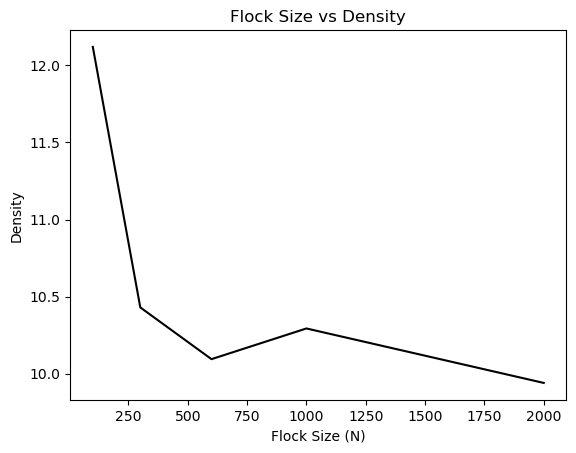

In [5]:
N = [100, 300, 600, 1000, 2000]

densities = []

for n in N:
    # We have to scale the box size, interaction, and repulsion radius as N gets bigger to get real proportional density measures,
    box_size = n**(1/3)
    R = 0.2 * box_size
    repulsion_radius = 0.1 * box_size

    position = run_simulation(
            N=n,
            steps=steps,
            box_size=box_size,
            align=align,
            cohesion=cohesion,               
            noise=noise,
            R=R,
            speed=speed,
            repulsion_radius=repulsion_radius,
            repulsion_strength=repulsion_strength,
            
            use_predator=False,
            predator_strength=5.0,         
            #defaults to 3*R
            predator_radius=None,
            #defaults to 1 * speed 
            predator_speed=None,           
            
            dt=0.1,
            seed=None,
            save_every=1,
            softening=1e-6,
        )
    densities.append(
    flock_density(position[-1], box_size=box_size)
)

plt.figure()
plt.plot(N, densities, 'k-')
plt.xlabel("Flock Size (N)")
plt.ylabel("Density")
plt.title("Flock Size vs Density")
plt.savefig("../figures/flock_density_N.png", dpi=200)
plt.show()

After correcting for container effects by scaling system size with flock size, the simulation exhibits approximately size-independent density, consistent with empirical measurements of starling flocks.

# Thickness vs Volume

To characterize the three-dimensional structure of the simulated flock, we analyze the final agent positions using principal component analysis (PCA). This method identifies three orthogonal directions along which the spatial spread of the aggregation is largest. The corresponding principal dimensions represent the main geometric extents of the flock: the largest dimension captures the overall length of the flock, the intermediate dimension describes its width, and the smallest dimension corresponds to the flock’s thickness.

The second experiment examines how flock thickness scales with the overall flock size by plotting the smallest PCA dimension against the cube root of the flock volume for increasing numbers of agents. As the number of agents increases, the emergent flock volume grows. We compare the flock thickness to the cube root of this volume, which represents a linear size scale of the flock, to test whether larger flocks are geometrically scaled versions of smaller ones.

# Aspect ratio vs Flock Size

The flocks aspect ratios is defined by the ratio two larger dimensions, length and width, and thickness, the smallest dimension. By examining how these quantities change with flock size, we can determine whether larger flocks preserve their overall shape while scaling in size, as observed in empirical studies of real starling flocks.

In [6]:
from scipy.spatial import ConvexHull

def pca_axes(pos):
    X = pos - pos.mean(axis=0)
    C = (X.T @ X) / X.shape[0]
    evals, _ = np.linalg.eigh(C)
    evals = np.sort(evals)[::-1]  # largest -> smallest
    # Axis-length proxies (proportional to std dev along axes)
    I3, I2, I1 = np.sqrt(np.maximum(evals, 0))
    return I1, I2, I3

def hull_volume(pos):
    # Convex hull volume proxy
    hull = ConvexHull(pos)
    return hull.volume

In [7]:
Ns = [100, 300, 600, 1000, 2000]
results = []

for n in Ns:
    box_size = n**(1/3)  # your scaling fix

    history = run_simulation(
        N=n,
        box_size=box_size,
        R=0.2 * box_size,
        repulsion_radius=0.1 * box_size,
        cohesion=0.2,
        repulsion_strength=2.0,
        align=1.0,
        noise=0.1,
        steps=600,
        seed=42
    )

    pos = history[-1]
    V = hull_volume(pos)
    I1, I2, I3 = pca_axes(pos)

    results.append({
        "N": n,
        "V": V,
        "V13": V**(1/3),
        "I1": I1,
        "I2I1": (I2 / (I1 + 1e-12)),
        "I3I1": (I3 / (I1 + 1e-12)),
    })


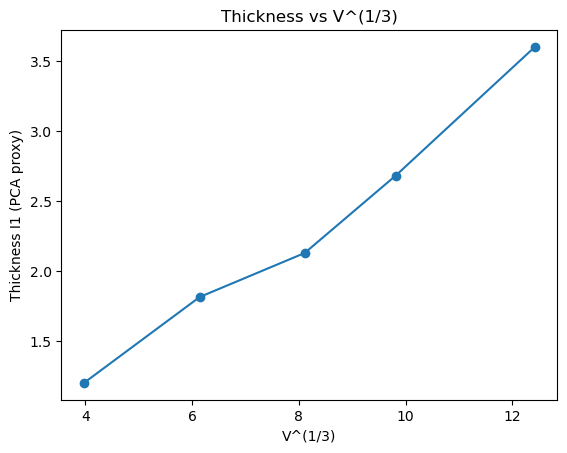

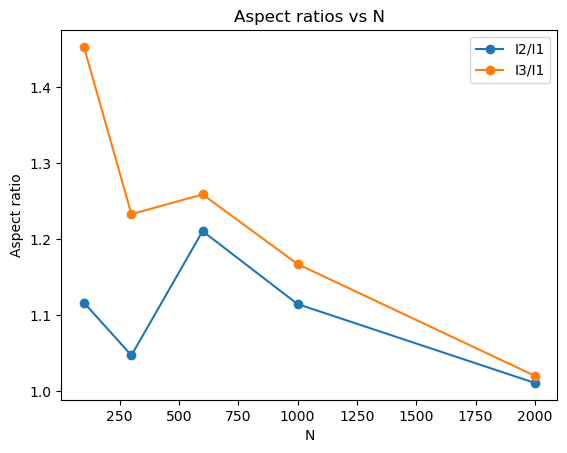

In [8]:
V13 = [r["V13"] for r in results]
I1  = [r["I1"]  for r in results]
I2I1 = [r["I2I1"] for r in results]
I3I1 = [r["I3I1"] for r in results]

plt.figure()
plt.plot(V13, I1, marker="o")
plt.xlabel("V^(1/3)")
plt.ylabel("Thickness I1 (PCA proxy)")
plt.title("Thickness vs V^(1/3)")
plt.show()

plt.figure()
plt.plot(Ns, I2I1, marker="o", label="I2/I1")
plt.plot(Ns, I3I1, marker="o", label="I3/I1")
plt.xlabel("N")
plt.ylabel("Aspect ratio")
plt.title("Aspect ratios vs N")
plt.legend()
plt.show()


The first figure graphs thickness of the flock in relation to cube root of the flocks volume. Flock volume grows naturally as N increases, therefore, taking the cube root of the volume linearly scales the flock size. The results show that as flock volume grows, thickness grows proportionally to the cube root of volume. Bigger flocks are geometrically scaled-up versions of smaller flocks. In essence, this result matches the literature.

The second figure plots aspect ratios as flock size grows. Our graph shows that both ratios hover around 1.0–1.3 and no strong trend with N. On the other hand, the paper's result displays that aspect ratios are approximately constant across very different flock sizes, meaning it is independent from N. 